In [37]:
import math
import numpy as np
import pandas as pd
import scikitplot as skplt
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

In [36]:
pip install scikit-plot

In [ ]:


data = pd.read_csv('/content/drive/MyDrive/fer/fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
data.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
emotion_labels = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [ ]:
data.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


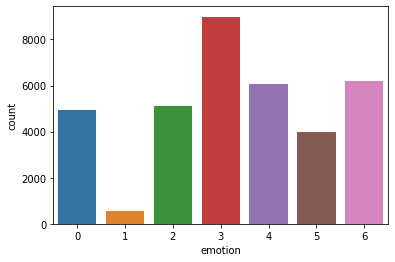

In [ ]:
sns.countplot(data.emotion)
pyplot.show()

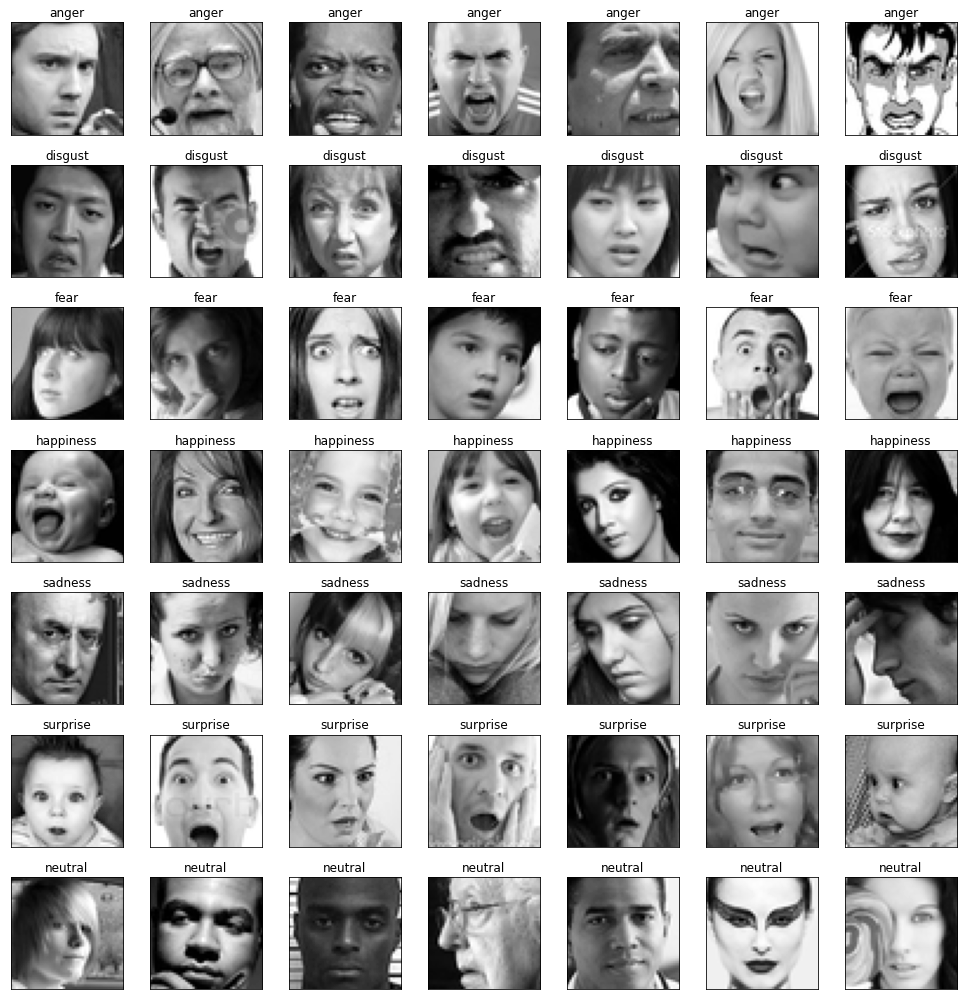

In [ ]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(data.emotion.unique()):
    for j in range(7):
        px = data[data.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_labels[label])
        pyplot.tight_layout()

In [ ]:
used_labels=[3,6,4,2,0]

In [ ]:
data = data[data.emotion.isin(used_labels)]
data.shape

(31338, 3)

In [ ]:
img_array = data.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [ ]:
img_array.shape

(31338, 48, 48, 1)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
LE= LabelEncoder()
image_labels = LE.fit_transform(data.emotion)
image_labels = np_utils.to_categorical(image_labels)
image_labels[5]


array([0., 1., 0., 0., 0.], dtype=float32)

In [ ]:
LE.classes_

array([0, 2, 3, 4, 6])

In [ ]:
LE_name_mapping = dict(zip(LE.classes_, LE.transform(LE.classes_)))
print(LE_name_mapping)

{0: 0, 2: 1, 3: 2, 4: 3, 6: 4}


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, image_labels,
                                                    shuffle=True, stratify=image_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((28204, 48, 48, 1), (3134, 48, 48, 1), (28204, 5), (3134, 5))

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [ ]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [ ]:
"""
Using two callbacks  , one is `early stopping` for avoiding overfitting training data
and another is  `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [ ]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [ ]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]


model = build_net(optims[1]) 
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


Epoch 1/100
881/881 [==============================] - 2190s 2s/step - loss: 1.7965 - accuracy: 0.2703 - val_loss: 1.4821 - val_accuracy: 0.3663 - lr: 0.0010
Epoch 2/100
881/881 [==============================] - 2141s 2s/step - loss: 1.5095 - accuracy: 0.3452 - val_loss: 1.3409 - val_accuracy: 0.4438 - lr: 0.0010
Epoch 3/100
414/881 [=============>................] - ETA: 18:19 - loss: 1.4132 - accuracy: 0.3919

In [108]:
model_70 = model.to_json()
with open("model.70", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model.h5")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

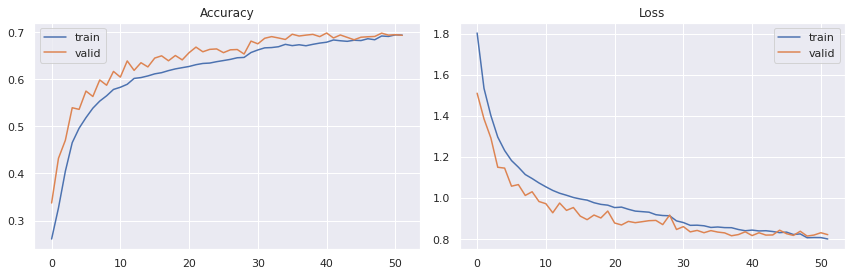

In [32]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

In [41]:
import tensorflow as tf; print(tf.__version__)

2.7.0


total wrong validation predictions: 944


              precision    recall  f1-score   support

           0       0.65      0.64      0.64       495
           1       0.62      0.50      0.55       512
           2       0.89      0.89      0.89       899
           3       0.61      0.60      0.61       608
           4       0.61      0.73      0.66       620

    accuracy                           0.70      3134
   macro avg       0.68      0.67      0.67      3134
weighted avg       0.70      0.70      0.70      3134



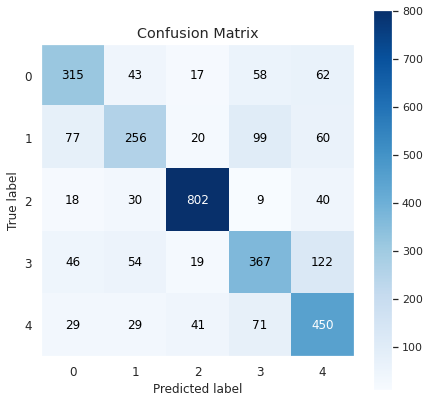

In [45]:
predict_x = model.predict(X_valid)
classes_x = np.argmax(predict_x,axis= 1)
skplt.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), classes_x,figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != classes_x)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), classes_x))

In [48]:
mapper = {
    0: "angry",
    1: "fear",
    2: "happy",
    3: "sad",
    4: "neutral"
}



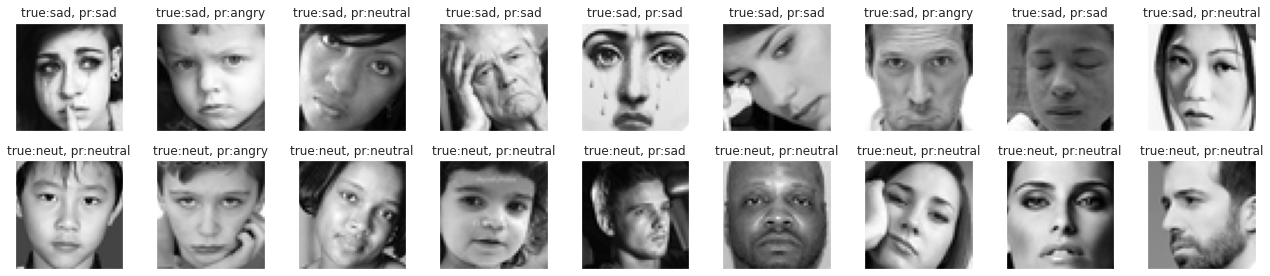

In [99]:
np.random.seed(2)


random_sad_imgs = np.random.choice(np.where(y_valid[:, 3]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 4]==1)[0], size=9)




fig = pyplot.figure(1, (18, 4))

for i, ( sadidx, neuidx ) in enumerate(zip(random_angry_imgs,random_fear_imgs ,random_happy_imgs,random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:sad, pr:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1))[0])]}")

       

        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:neut, pr:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1))[0])]}")



        pyplot.tight_layout()




        


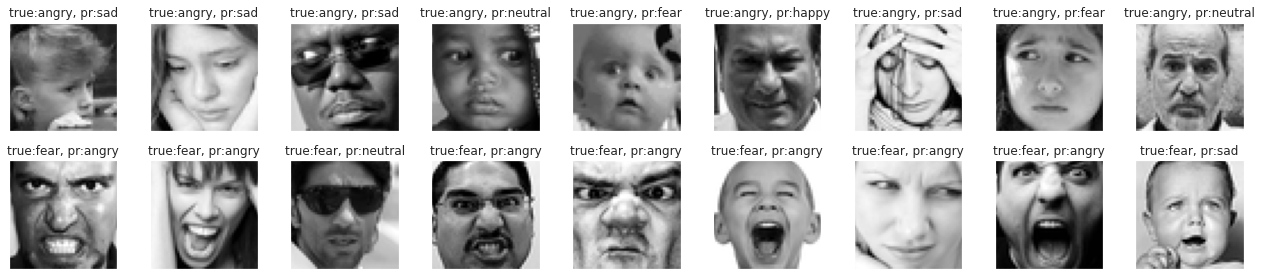

In [107]:
np.random.seed(2)

random_angry_imgs = np.random.choice(np.where(y_valid[:, 0]==1)[0], size=9)
random_fear_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
# random_happy_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)





fig = pyplot.figure(1, (18, 4))

for i, (fearidx , angryidx ) in enumerate(zip(random_angry_imgs,random_fear_imgs )):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[angryidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:angry, pr:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1))[0])]}")

       

        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[fearidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:fear, pr:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1))[0])]}")



        pyplot.tight_layout()








